In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.ticker as ticker
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Contraction import contraction_lookup
tf.get_logger().setLevel('ERROR')

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 62s 1us/step


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 20000
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=5000,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 3 classes.
Using 20000 files for training.
Found 25000 files belonging to 3 classes.
Using 5000 files for validation.


In [4]:
max_length = 300
trunc_type = 'post'
padding_type = 'post'

In [5]:
max_vocab_size = 5000


In [6]:
def preprocess(df):

    inp=[t.numpy() for t,_ in df.take(20000)]
    label=[l.numpy() for _,l in df.take(20000)]
    inp=inp[0]
    inp=inp.reshape(-1,1)
    
    inp=np.apply_along_axis(lambda x:list(map(lambda y:y.decode("utf-8"),x)),1,inp).tolist()
   
    inp_df=pd.DataFrame(data={"text":inp})

    inp_df['text']=inp_df['text'].apply(lambda x:"".join(x))
    inp_df.loc[:,'text']=inp_df.text.replace(contraction_lookup,regex=True)
    inp_df.loc[:,'text']=inp_df.text.replace({" br ":" "},regex=True)
    inp_df.loc[:,'text']=inp_df['text'].apply(lambda x:re.sub("[^a-zA-Z0-9\"']"," ",x))
    inp_df.loc[:,'text']=inp_df['text'].apply(lambda x:x.lower())

    inp_df['label']=label[0]
    
    return inp_df

In [7]:
train_inp_df=preprocess(train_ds)

In [8]:
X_train,_,y_train,_=train_test_split(train_inp_df['text'].values,train_inp_df['label'].values,test_size=0.5,stratify=train_inp_df['label'].values)

In [9]:
train_inp_df=pd.DataFrame(data={"text":X_train,"label":y_train})

In [10]:
train_inp=tf.constant(train_inp_df["text"].values)
train_y=tf.constant(train_inp_df['label'].values)

In [11]:
train_text=train_inp_df['text'].values.tolist()

In [78]:
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
dict(list(word_index.items()))

In [13]:
train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
test_inp=preprocess(test_ds)

In [15]:
test_sequences=tokenizer.texts_to_sequences(test_inp['text'].values.tolist())
test_padded=pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
train_padded=tf.constant(np.array(train_padded))
train_label=tf.constant(train_inp_df['label'].values)
train_label=tf.keras.utils.to_categorical(train_label, num_classes=2, dtype='float32')

In [17]:
test_padded=tf.constant(np.array(test_padded))
test_label=tf.constant(test_inp['label'].values)
test_label=tf.keras.utils.to_categorical(test_label, num_classes=2, dtype='float32')

In [18]:
train_data=tf.data.Dataset.from_tensor_slices((train_padded, train_label))
test_data=tf.data.Dataset.from_tensor_slices((test_padded, test_label))


In [19]:
train_batch=train_data.batch(64)
test_batch=test_data.batch(64)

In [20]:
def mask_sequence(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen,
                    dtype=tf.float32)[None, :] < tf.cast(
                        valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

In [21]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = mask_sequence(tf.reshape(X, shape=(-1, shape[-1])),
                              valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

In [22]:
class Attention_model(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(1, use_bias=False)
        

    def call(self, keys, values, valid_lens, **kwargs):
        keys=tf.expand_dims(keys,1)
       
        keys = self.W_k(keys)
        features = tf.nn.tanh(keys)
        
        scores=tf.squeeze(features,axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        return self.attention_weights,tf.matmul(self.attention_weights,values)

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,activation='tanh',
                                       # Return the sequence and state
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.dense = tf.keras.layers.Dense(2, activation=None, name='classifier')
    def call(self, tokens, state=None):
        
        valid_len=tf.reduce_sum(tf.cast(tokens!=0,tf.int16),axis=1)
        mask=tokens!=0
        
        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
    
        
        
        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors,mask=mask)
        key_size=output.shape[-1]
        attention_model=Attention_model(64)
        attention_weights,context_vec=attention_model(output,output,valid_len)
        out=tf.reshape(context_vec,(context_vec.shape[0],-1))
        
        out=self.dense(out)
        
        # 4. Returns the new sequence and its state.
        
        return out,attention_weights

In [29]:
embedding_dim=256
units=512

encoder = Encoder(len(word_index),
                  embedding_dim, units)


In [30]:
epochs = 6
init_lr = 3e-4
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_metric=tf.keras.metrics.CategoricalAccuracy()


In [31]:
for epoch in range(epochs):
    for batch_idx,(x_batch,y_batch) in enumerate(train_batch):
        with tf.GradientTape() as tape:
        
            y_pred,weights=encoder(x_batch,training=True)
            loss=loss_fn(y_batch,y_pred)
        
        gradients=tape.gradient(loss,encoder.trainable_weights)
        optimizer.apply_gradients(zip(gradients,encoder.trainable_weights))
        acc_metric.update_state(y_batch,y_pred)
    print("loss",loss)
    train_acc=acc_metric.result()
    print(f"Accuracy over epoch {epoch},acc:{train_acc}")
    acc_metric.reset_states()


loss tf.Tensor(0.30901605, shape=(), dtype=float32)
Accuracy over epoch 0,acc:0.7263000011444092
loss tf.Tensor(0.16289563, shape=(), dtype=float32)
Accuracy over epoch 1,acc:0.8694000244140625
loss tf.Tensor(0.088192545, shape=(), dtype=float32)
Accuracy over epoch 2,acc:0.8964999914169312
loss tf.Tensor(0.08984621, shape=(), dtype=float32)
Accuracy over epoch 3,acc:0.9057000279426575
loss tf.Tensor(0.07259907, shape=(), dtype=float32)
Accuracy over epoch 4,acc:0.8980000019073486
loss tf.Tensor(0.042277087, shape=(), dtype=float32)
Accuracy over epoch 5,acc:0.9179999828338623


In [74]:
for batch_idx,(x_batch,y_batch) in enumerate(test_batch):
    
    y_pred,_=encoder(x_batch,training=True)
    loss=loss_fn(y_batch,y_pred)
    acc_metric.update_state(y_batch,y_pred)

train_acc=acc_metric.result()
print("Accuracy over test set",train_acc)
acc_metric.reset_states()

Accuracy over test set tf.Tensor(0.802, shape=(), dtype=float32)


In [65]:
x='I rarely stop watching a movie although how crappy it is. Well for this one I made an exception since its beyond boring. I can not leave long reviews so this is it.. SKIP IT'

In [66]:
text=x.replace(","," ")
text=text.replace("."," ")
len_=len(text.split())

In [67]:
def inference(text):

    example=[text]
    seq=tokenizer.texts_to_sequences(example)
    seq_pad=pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    weight_array=[]
    best_prob=0
    for _ in range(75):
        y_pred,weights=encoder(seq_pad,training=False)
        pred=tf.keras.activations.softmax(y_pred)
        prob=tf.reduce_max(pred)
        if prob>best_prob:
            attn_weights=weights
            best_prob=prob
    return attn_weights,pred
    

In [68]:
attn_weights,pred=inference(text)

In [69]:
weights=attn_weights[0,0,:len_]

In [70]:
pred_map={0:"Negative",1:"Positive"}
prediction=np.argmax(pred.numpy())
label=text.split()
prediction_label=pred_map[prediction]

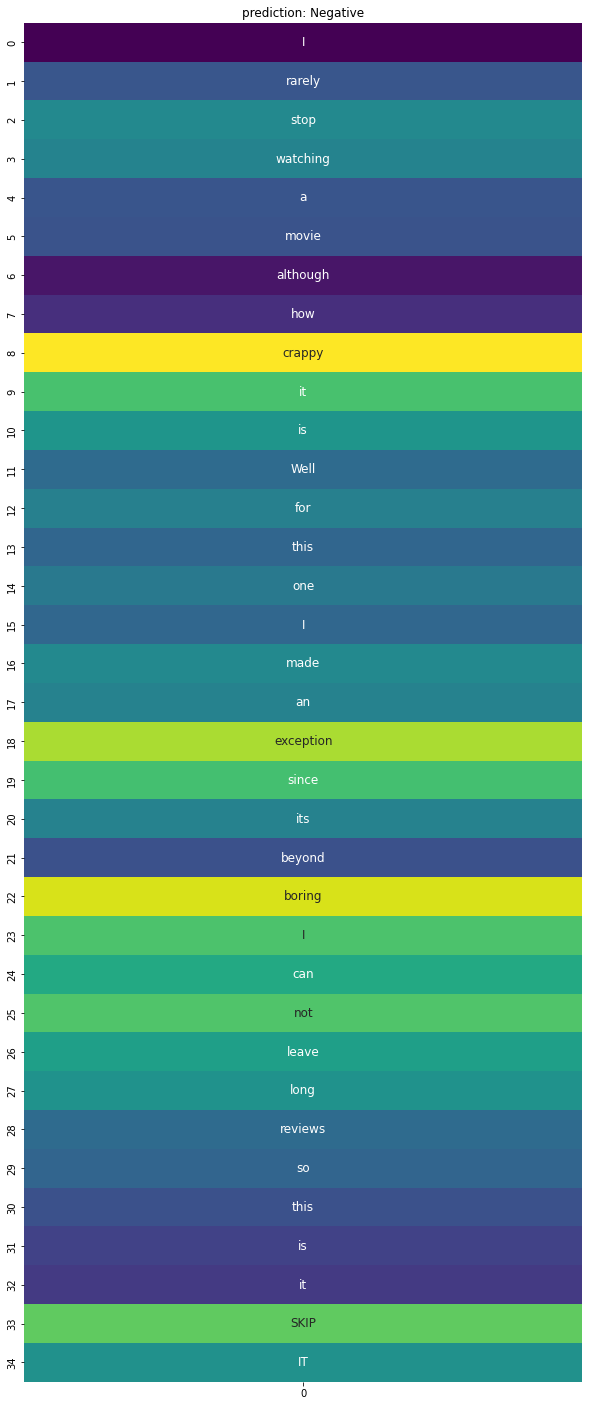

In [77]:
fig, ax = plt.subplots(figsize=(10,25))
labels =  np.array(list(map(lambda x:[x],label))).reshape(weights.shape[0],1)
plt.title(f"prediction: {prediction_label}")
sns.heatmap(weights.numpy().reshape(weights.shape[0],1),annot_kws={"fontsize":12}, annot = labels, fmt = '',cmap="viridis",ax=ax,cbar=False)
plt.savefig("output.png")
plt.show()